# Automobile Fuel Efficiency Predictions <a class="anchor" id="top"></a>

### Notebook by Justin Bandoro

In this project, we will be working with a dataset obtained from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Auto+MPG). The data concerns city-cycle fuel consumption in miles per gallon (MPG), to be predicted in terms of 3 multivalued discrete and 5 continuous attributes.

## Table of Contents:

1. [Problem Definition](#defineproblem)
2. [Preperation](#preperation)
3. [Checking the Data](#checking)
4. [Extracting Car Make](#carmake)
4. [Visualizing the Data](#visualize)
5. [Tidying and Pre-processing the Data](#tidying)
6. [Simple Ordinary Least Squares Regression](#linear)
7. [Testing Regression Models: Baseline](#testing)
8. [Tuning Models: K-Nearest Neighbors](#tuningknn)
9. [Tuning Models: Ridge Regression](#tuningridge)
10. [Tuning Models: SVM Regression](#tuningsvm)
11. [Ensemble Methods](#ensemble)
12. [Tuning Ensemble Methods: Gradient Boosting](#tuninggbm)
13. [Finalize Models](#finalize)
14. [Summary](#summary)



## Problem Definition <a class="anchor" id="defineproblem"></a>
[[back to top]](#top)


Let's pretend we are in a situation where it was found out that the automobile giants lied to public about published fuel consumption efficiencies their older, now antique, cars. All that is available is a dataset of actual verified fuel efficiencies for these older 1970s and early 1980s automobiles. 

<img src='oldcar.jpeg'>


Using attributes of unknown cars such as number of cylinders, horsepower, and weight, we are tasked to identify the miles per galon (MPG) without taking it for an exhaustive test drive over city conditions. 

In this problem we seek to predict the MPG for a given car's attributes: 

1. cylinders:     multi-valued discrete
2. displacement:  continuous
3. horsepower:    continuous
4. weight:        continuous
5. acceleration:  continuous
6. model year:    multi-valued discrete
7. origin:        multi-valued discrete, 1 = usa; 2 = europe; 3 = japan
8. car name:      string (unique for each instance)

Since this a regression problem, we will use the Mean Squared Error (MSE) as the performance metric to quantify how well our model is performing.

## Preperation <a class="anchor" id="preperation"></a>
[[back to top]](#top)

Here we load some of the necessary packages that we'll need to work through this project. As well as load in the data into Pandas. We know that missing values were marked as "?" so we can change them to NaN when reading in the data.

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('precision',1) #easy to read output

# Load data 
names = ['mpg','cyl','disp','hp','weight','accel','year','orig','name']
data  = pd.read_csv('auto-mpg.data.csv',names=names,delim_whitespace=True,na_values=['?'])
display(data.head())

,mpg,cyl,disp,hp,weight,accel,year,orig,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Checking the data

Here we will look at the data and check the number if there are missing values and if anything looks wrong with the data.

In [2]:
display(data.isnull().sum() )
data['name'] = data['name'].astype('category') 
data['orig'] = data['orig'].astype('category')
display(data.dtypes)
display(data.describe())

mpg       0
cyl       0
disp      0
hp        6
weight    0
accel     0
year      0
orig      0
name      0
dtype: int64

mpg        float64
cyl          int64
disp       float64
hp         float64
weight     float64
accel      float64
year         int64
orig      category
name      category
dtype: object

,mpg,cyl,disp,hp,weight,accel,year
count,398.0,398.0,398.0,392.0,398.0,398.0,398.0
mean,23.5,5.5,193.4,104.5,2970.4,15.6,76.0
std,7.8,1.7,104.3,38.5,846.8,2.8,3.7
min,9.0,3.0,68.0,46.0,1613.0,8.0,70.0
25%,17.5,4.0,104.2,75.0,2223.8,13.8,73.0
50%,23.0,4.0,148.5,93.5,2803.5,15.5,76.0
75%,29.0,8.0,262.0,126.0,3608.0,17.2,79.0
max,46.6,8.0,455.0,230.0,5140.0,24.8,82.0


We have 398 samples in the dataset.

All of the values in the description above look reasonable, i.e. the min/max out of what we would expect. However we see that there are 6 missing values for horsepower that we'll have to deal with. 

It is also a good idea to visualize to see if there are any outliers/errors, and to get a general sense of the relationship between features themselves and with fuel efficiency. Though we will look at this more in detail later.

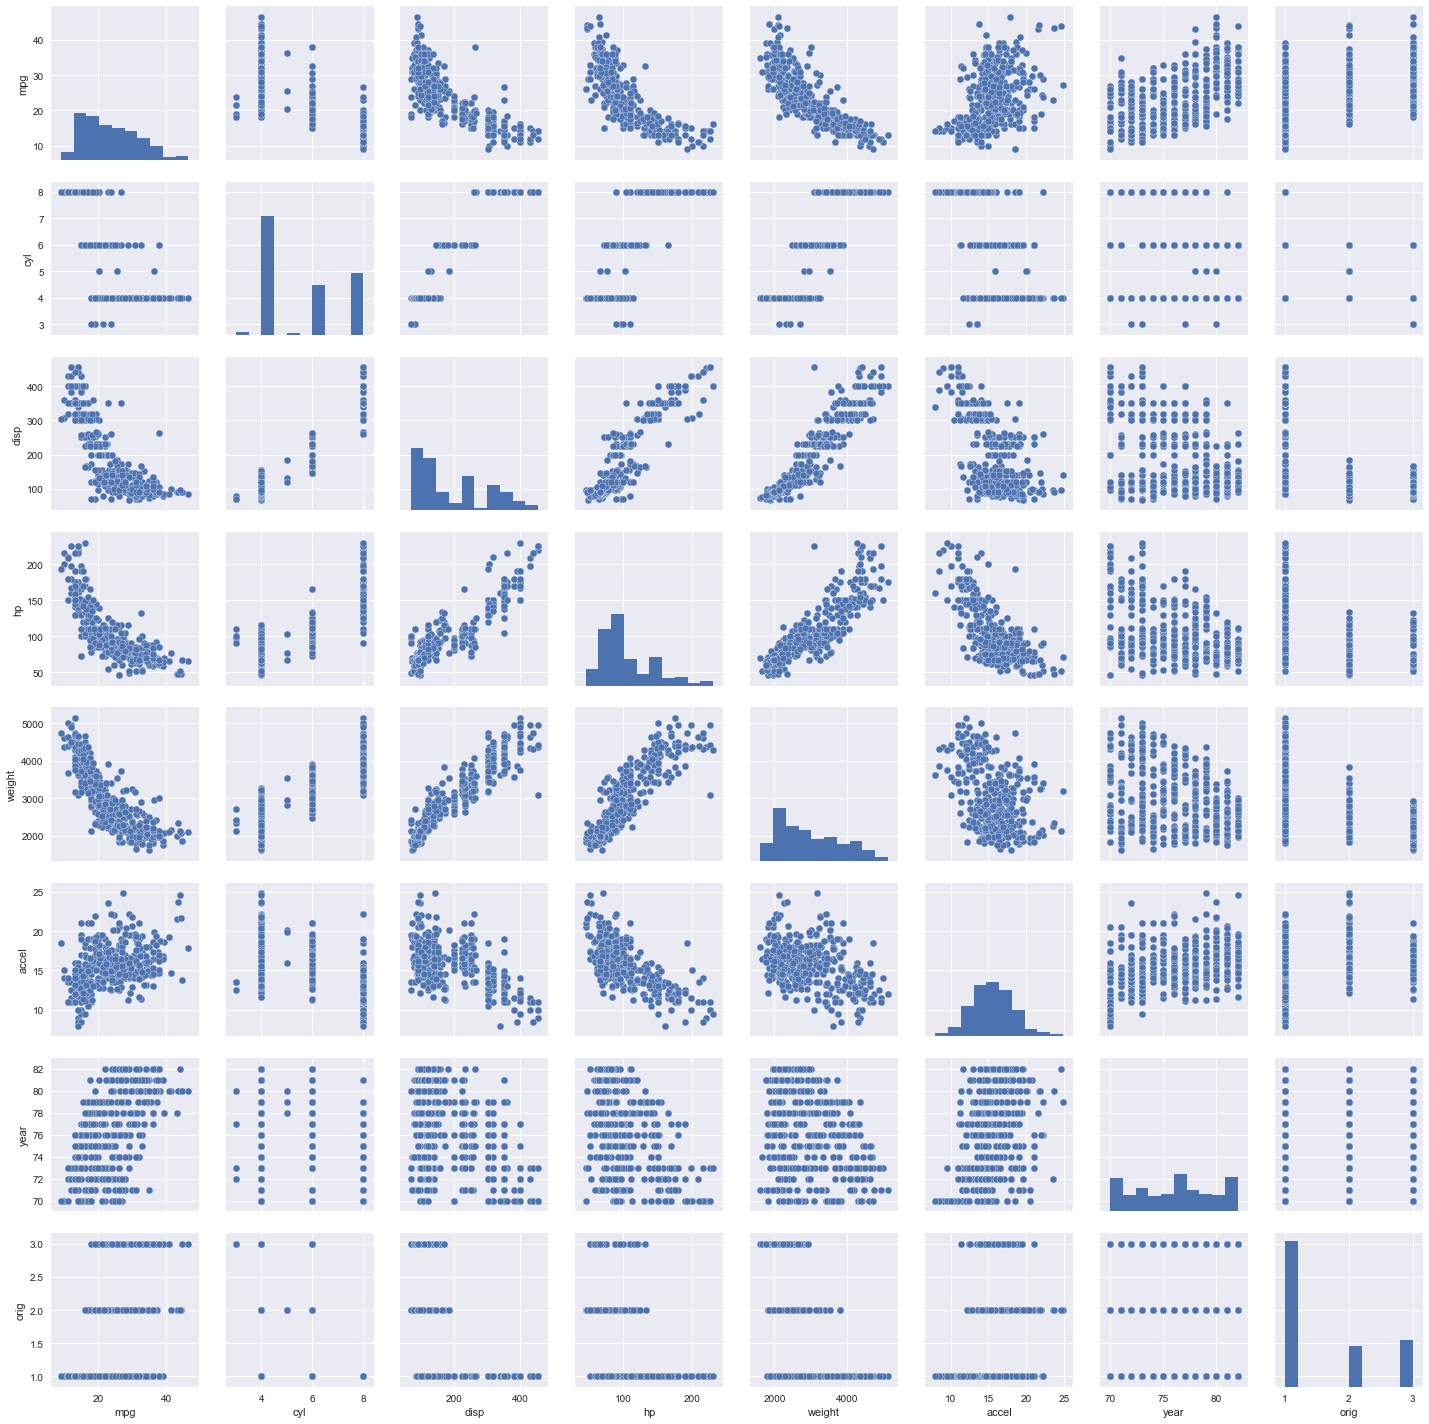

In [3]:
sns.pairplot(data.dropna())

From the strip and scatter plots above we see that horsepower, displacement, and weight are tightly correlated. This could be useful for imputing missing values for horsepower. MPG looks to exponentially decrease as weight, hp and disp increase.

Other than this the data looks pretty tidy. Let's define the feature types below since we have continous, ordinal, and categorical features.

In [4]:
feat_cont = ['disp','hp','weight','accel']
feat_ord  = ['cyl','year']
feat_cat  = ['name','orig']

## Extracting Car Make <a class="anchor" id="carmake"></a>
[[back to top]](#top)


We will look at the name feature which has both make and model. Let's extract the make names (ford,chevrolet, etc.) and look at the number of counts and mpg relationship.

The name is given in terms of make and model, e.g. 'plymouth satellite'. We want the first string which contains the car make.

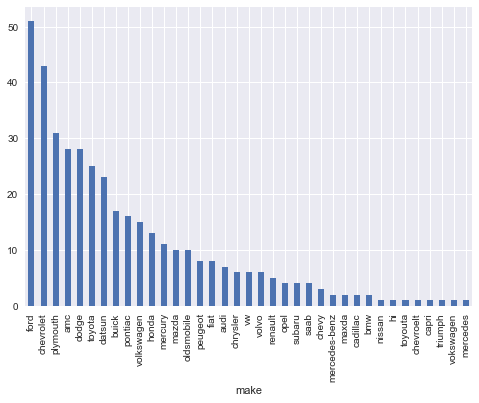

In [5]:
data['make'] = data.name.str.split(' ',2).str.get(0)
data.groupby(['make']).size().sort_values(ascending=False).plot.bar()

From the above, we see that there are numerous typos in the makes, for example 'toyouta'. There are shorthand names like 'vw' for 'volkswagen' or misspellings like 'vokswagen'. Lets fix this, and then plot boxplots of the fuel efficiencies for each make:

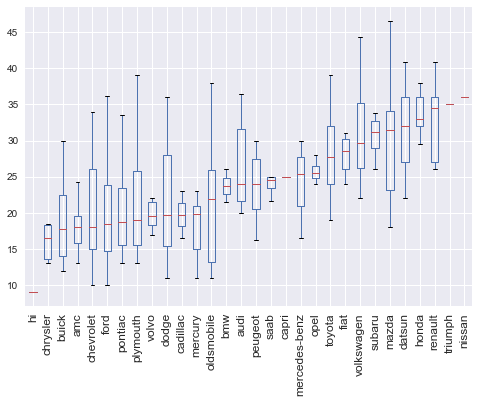

In [6]:
data['make'] = data['make'].replace(['chevroelt','chevy',],'chevrolet')
data['make'] = data['make'].replace(['vw','vokswagen'],'volkswagen')
data['make'] = data['make'].replace('maxda','mazda')
data['make'] = data['make'].replace('toyouta','toyota')
data['make'] = data['make'].replace('mercedes','mercedes-benz')

def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    return df2[meds.index].boxplot(rot=rot, return_type="axes")
axes=boxplot_sorted(data,'make','mpg',rot=90)

From the above there is considerable spread within the car makes. This is of course because many of the larger car manufacturers have a range of models that are both high and low fuel efficiencies. There are a select few car makes that are sparsely sampled in the data, like Nissan or Triumph that only have a single model. Thus the car make might not be very useful if we are given a new Nissan model that is not in the training dataset but is a model with higher/lower fuel efficiency than the model in the training data.

From the above we conclude that is not ideal if we were to train a machine learning model on the car make. For this reason we will drop the car make from the dataset (you can run this notebook with the make included as a categorical feature and the model prediction skill is worse). We could try to use model information, but there are too many different model types. An exhaustive approach would be to go in and parse out all of the models that are similar (e.g. 'civic' and 'civic gl'). In reality, cars from the same model should have similar engine attributes, and removinng this also safeguards against make/models that are not in the training set. 

In [7]:
# Dropping make and name from the dataset
data = data.drop(['name','make'],axis=1)

# The only categorical feature left is the origin
feat_cat = ['orig']

data.head() # dataset to use

,mpg,cyl,disp,hp,weight,accel,year,orig
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


# Visualizing the data <a class="anchor" id="visualizing"></a>
[[back to top]](#top)

Now we will visualize the features of the dataset and their relationship to MPG. First we will plot feature distributions to see their range and shape, then after we will look at scatter/bar plots of the features with MPG.

/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


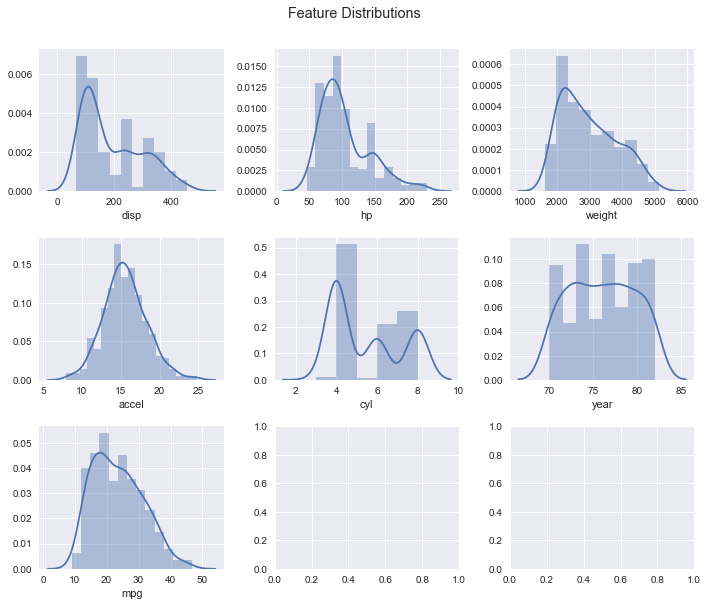

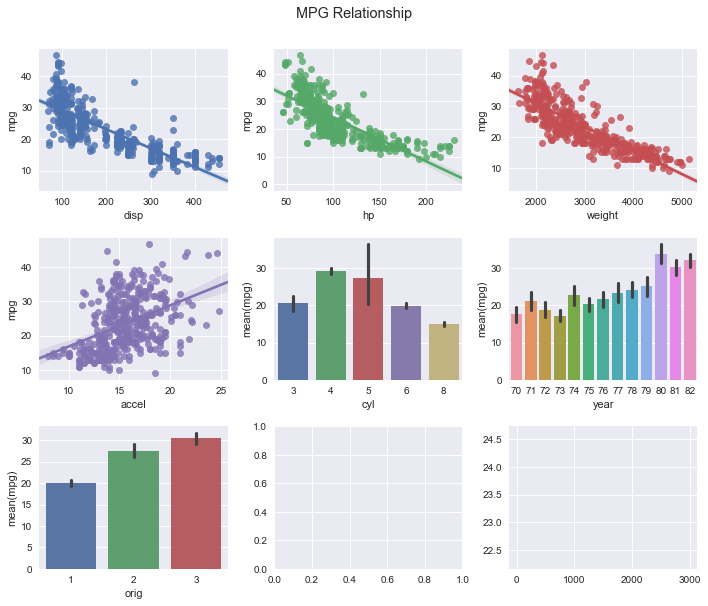

In [8]:
# Distribution plots
fig1,axes1 = plt.subplots(3,3,figsize=[10,8])

for ax1,feat in zip(axes1.ravel(),feat_cont+feat_ord+['mpg']):
    sns.distplot(data[feat].dropna(),ax=ax1)
fig1.tight_layout()

# Scatter and barplots for relationship to MPG
fig2,axes2 = plt.subplots(3,3,figsize=[10,8])
fig1.suptitle('Feature Distributions',y=1.05)
fig2.suptitle('MPG Relationship',y=1.05)
for ax2,feat in zip(axes2.ravel(),feat_cont):
    sns.regplot(x=feat,y='mpg',data=data.dropna(),ax=ax2)
for ax2,feat in zip(axes2.ravel()[len(feat_cont):],feat_ord+feat_cat):
    sns.barplot(x=feat,y='mpg',data=data.dropna(),ax=ax2)
fig2.tight_layout();fig2.tight_layout()

For the continuous features: displacement, horsepower and weight are skewed, while acceleration looks to be more normally distributed. The most common cylinder number is 4, origin is highest from USA/North America, and that there is almost equal distribution among the years.

As we noted earlier, in the relationship to MPG, we see that displacement, horsepower and weight have an exponentiual tail as mpg bottoms out at higher values of disp, hp, and weight. Also we see that cars originating from Japan and Europe are on average more fuel efficient than cars from North America.

Also there is a trend towards cars being more fuel efficient as the year increases.  

### Correlation Matrix

Correlation shows how related the changes between two variables are. Below we plot the correlation heatmap for the dataset for both ordinal and continuous features.

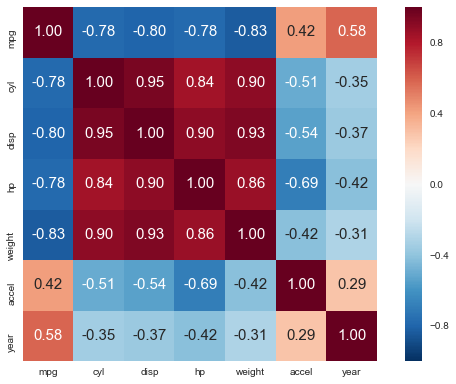

In [9]:
correlations = data.corr()
sns.heatmap(correlations, square=True,annot=True,fmt='.2f',annot_kws={'size':15})
plt.tight_layout()

From the correlation heatmap we notice that there is high corrleation between the following continuous attributes: **disp**, **hp**, **weight** and **cyl**. The colinearity between these features will affect linear models, so we'll have to impose methods against overfitting such as regularization if possible.

### Summary:

1. The ranges of the features can vary a couple orders of magnitude, it is a good idea to scale all the features to the same range.
2. The categorical **orig** feature is not ordinal, we will one hot encode it.
3. The features **cyl** and **year** are ordinal values, we should also scale them.
4. We will impute missing **hp** values in the training/test data from the training dataset using simple ordinaly least squares regression with weight.

## Tidying and Pre-processing the Data <a class="anchor" id="tidying"></a>
[[back to top]](#top)

The only error in continuous and discrete features we identified in dataset, was the missing values of horsepower. We will impute these based on weight and displacement. From this point forward, we will be working with a training set, while holding out a validation/test set for later use.

Since the dataset is relatively small with 394 total samples, this means we should use a more conservative split for training and test data. Here we will use a 60/40 training/test split.

Below we also choose the scaler to use for pre-processing of data. We ended up choosing normalizing over standardization as it resulted in the best model.

### Train/test Splitting

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error


X = data.drop(['mpg'],axis=1); y = data['mpg']

#Size for train/test split
test_size=0.4
Xtrain, Xtest,ytrain,ytest = train_test_split(X, y, test_size=test_size, random_state=7)

# Choose the scaler to use for pre-processing of data
scaler = MinMaxScaler() #StandardScaler()

# Predictions dataframe to store predictions from models 
Predictions = pd.DataFrame({'y_true':ytest})

### Transformer Classes 

Below are custom sklearn transformer classes that we construct, so that we can use them in pipelines. The first below is an imputer for horsepower based on car weight:

In [11]:
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion

class HPImputer(BaseEstimator,TransformerMixin):
    """ Imputer that uses the fitted data to get the coefficients of a 1st degree
        polynomial to use for imputing horsepower from weight
    """
    def __init__(self):
        pass
        
    def transform(self, X, *_):
        # Check for missing values of HP
        misshp = np.isnan(X.hp)
        # No missing values
        if ~np.any(misshp):
            return X 
        Xret = X.copy()
        # Weights corresponding to missing HP
        missweight = X.loc[X.hp.isnull(),'weight']
        hp_est     = self.a*missweight + self.b
        Xret.loc[X.hp.isnull(),'hp'] = hp_est
        return Xret
    
    def fit(self,X, y=None):
        weight = X.loc[X.hp.notnull(),'weight']
        hp     = X.loc[X.hp.notnull(),'hp']
        #Fit polynomial of degree 1 to weight and horsepower
        p = np.polyfit(weight,hp,1)
        self.a = p[0]
        self.b = p[1]
        return self

The second transformer below one hot encodes all categorical variables present in the dataset:

In [12]:
from itertools import chain

class CategoricalTransformer(BaseEstimator,TransformerMixin):
    """ Taken from https://tomaugspurger.github.io/categorical-pipelines.html
    """
    def fit(self, X, y=None, *args, **kwargs):
        self.columns_ = X.columns
        self.cat_columns_ = X.select_dtypes(include=['category']).columns
        self.non_cat_columns_ = X.columns.drop(self.cat_columns_)

        self.cat_map_ = {col: X[col].cat.categories
                         for col in self.cat_columns_}
        self.ordered_ = {col: X[col].cat.ordered
                         for col in self.cat_columns_}

        self.dummy_columns_ = {str(col): ["_".join([str(col), str(v)])
                                     for v in self.cat_map_[col]]
                               for col in self.cat_columns_}
        self.transformed_columns_ = pd.Index(
            self.non_cat_columns_.tolist() +
            list(chain.from_iterable(self.dummy_columns_[k]
                                     for k in self.cat_columns_))
        )
        return self

    def transform(self, X, y=None, *args, **kwargs):
        return (pd.get_dummies(X)
                  .reindex(columns=self.transformed_columns_)
                  .fillna(0))

    def inverse_transform(self, X):
        X = np.asarray(X)
        series = []
        non_cat_cols = (self.transformed_columns_
                            .get_indexer(self.non_cat_columns_))
        non_cat = pd.DataFrame(X[:, non_cat_cols],
                               columns=self.non_cat_columns_)
        for col, cat_cols in self.dummy_columns_.items():
            locs = self.transformed_columns_.get_indexer(cat_cols)
            codes = X[:, locs].argmax(1)
            cats = pd.Categorical.from_codes(codes, self.cat_map_[col],
                                             ordered=self.ordered_[col])
            series.append(pd.Series(cats, name=col))
        # concats sorts, we want the original order
        df = (pd.concat([non_cat] + series, axis=1)
                .reindex(columns=self.columns_))
        return df

### Example: Walking through pre-processing steps

Even though we will wrap all of the above steps into a pipeline for final use in the model testing, below we show an example of working through the steps, and then the final pipeline.

#### Imputing Horsepower:

In [13]:
# Imputing Horsepower
Xexample = HPImputer().fit_transform(Xtrain)
Xexample.isnull().sum()

cyl       0
disp      0
hp        0
weight    0
accel     0
year      0
orig      0
dtype: int64

Can see we eliminated the missing horsepower values with imputing from the first order polynomial with the weight feature. Next we'll one hot encode the orig attribute.

#### One Hot Encode Categorical Features:

In [14]:
Xexample = CategoricalTransformer().fit_transform(Xexample)
Xexample.head()

,cyl,disp,hp,weight,accel,year,orig_1,orig_2,orig_3
380,4,120.0,88.0,2160.0,14.5,82,0,0,1
335,4,122.0,88.0,2500.0,15.1,80,0,1,0
193,6,200.0,81.0,3012.0,17.6,76,1,0,0
177,4,115.0,95.0,2694.0,15.0,75,0,1,0
174,6,171.0,97.0,2984.0,14.5,75,1,0,0


Above the orig has been one hot encoded. 1=USA, 2=Europe, 3=Japan. The next step is to scale the dataset.

#### Scaling the dataset:

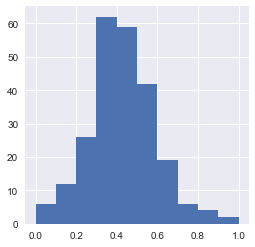

In [15]:
example = scaler.fit_transform(Xexample)
Xexample = pd.DataFrame(example,columns=Xexample.columns.values)
# Plot standardized acceleration for example
fig,ax = plt.subplots(1,figsize=[4,4])
out = ax.hist( Xexample['accel'],bins=10)

The features are now scaled to be in the same range.

## Simple Ordinary Least Squares Regression<a class="anchor" id="linear"></a>
[[back to top]](#top)

To first get an estimate of how well our machine learning models are doing, let us just see what the MSE acheived is if we were only to do OLS regression on the highest correlated feature we found: **weight**. 

As in future steps, since we have a relatively small dataset, we use a large number of cross-validation (CV) folds, a 10 fold cross-validation test harness to score the model.

OLS Regression training data with weight MSE for 10-fold cross-validation: -19.483764688001923 (6.878751891393616)


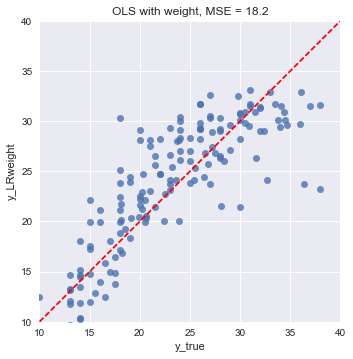

In [16]:
from sklearn.linear_model import LinearRegression

num_folds = 10

#Since we're only using 1 feature we have to reshape it into a column vector
weighttrain = Xtrain['weight'].values.reshape((Xtrain.shape[0],1))
weighttest  = Xtest['weight'].values.reshape((Xtest.shape[0],1))

#Pipeline for OLS model that includes scaling 
lr_pipe = make_pipeline(scaler, LinearRegression() )
lr_results = cross_val_score(lr_pipe, weighttrain, ytrain, cv=num_folds, scoring='neg_mean_squared_error')

print('OLS Regression training data with weight MSE for {}-fold cross-validation: {} ({})'.format(
      num_folds,lr_results.mean(), lr_results.std()))

# Train on entire dataset
lr_pipe.fit(weighttrain,ytrain) 

# Predictions from test data
Predictions['y_LRweight'] =  lr_pipe.predict(weighttest)
lr_mse = mean_squared_error(Predictions['y_LRweight'],ytest)

# Make plot 
sns.lmplot(data=Predictions,x='y_true',y='y_LRweight',fit_reg=False);ax=plt.gca()
ax.set_ylim([10,40]);ax.set_xlim([10,40])
ax.set_aspect('equal')
ax.set_title('OLS with weight, MSE = {:0.1f}'.format(lr_mse))
ax.plot([10,40],[10,40], 'r--')

Can see from the above that with only car weight as predictor we get a MSE of 18.2 which corresponds to a RMSE of around 4.3 MPG. From eyeing the above we can see there is a bias for the LR model to overestimate MPG. This is probably due to the exponential relationship we saw earlier.

In the next step we will test out a variety of regression models and we can compare their scores to this simple example. 

## Testing Regression Models: Baseline<a class="anchor" id="testing"></a>
[[back to top]](#top)

In this section we will test out of the box a few linear and non-linear regression models to compare at first glance which ones do a better job. We do not know what algorithms will perform well. First we'll make a test harness which will be the 10-fold cross-validation. We will evaluate models using the Mean Squared Error (MSE) metric. MSE gives a gross idea of how wrong all the predictions are. 

- **Linear algorithms**:  Ridge, Lasso, and Elastic Net regressors
- **Nonlinear algorithms**: Decision tree, Support vector machine (SVM), and K-Nearest Neighbors (KNN) regressors

MSE mean:


RIDGE   -12.1
LASSO   -30.2
ENET    -38.3
KNN      -9.6
DTREE   -12.5
SVM     -17.5
dtype: float64

MSE std:


RIDGE     4.7
LASSO    10.9
ENET     10.7
KNN       3.6
DTREE     4.3
SVM       7.6
dtype: float64

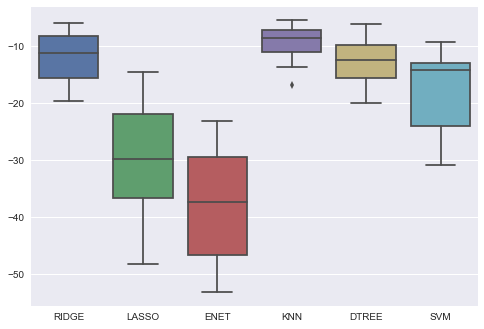

In [17]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

#K-fold harness
num_folds = 10
kfold     = KFold(n_splits=num_folds,random_state = 7)

#All models
models = { 'RIDGE' : Ridge(),
           'LASSO': Lasso(),
           'ENET': ElasticNet(),
           'KNN':  KNeighborsRegressor(),
           'DTREE' : DecisionTreeRegressor(),
           'SVM': SVR()
        }
modelkeys = models.keys()

#Evaluate Models
Results = pd.DataFrame(columns=modelkeys)
scoring = 'neg_mean_squared_error'
for name in modelkeys:
    pipeline = make_pipeline( HPImputer(),CategoricalTransformer(),scaler, models[name] )
    cv_results = cross_val_score(pipeline, Xtrain, ytrain, cv=kfold, scoring=scoring)
    Results[name] = cv_results

print('MSE mean:')
display(Results.mean())
print('MSE std:')
display(Results.std())

#Visualize
sns.boxplot(data=Results)

We see that with default parameters, the MSE mean of the models do better than our benchmark against OLS of car weight. This is good, we would hope that adding additional information would help! 

We will take three of models that have potential to be better and tune their parameters to see how well we can do for the regression. We'll focus on these 3:

1. K-Nearest Neighbors Regression
2. Ridge Regression
3. Support Vector Machine Regression

Below is a quick function to take the grid search results and present them clearly:

In [18]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Tuning Models: K-Nearest Neighbors<a class="anchor" id="tuningknn"></a>
[[back to top]](#top)

Here we will tune the hyperparameters for K-Nearest Neighbors Regression. The grid search will be performed for the following parameters:

* **n_neighbors**: Number of neighbors to use.
* **weights**: Weight function used in prediction, we will try 'uniform', points weighted uniformly, and 'distance', points weighted by distance.

In [19]:
#Pipeline for KNN Regressor
knn_pipe = make_pipeline( HPImputer(), CategoricalTransformer(), scaler, KNeighborsRegressor() )

#Set up grid search
param_grid = {'kneighborsregressor__n_neighbors':np.array([2,3,4,5,6,8,10]),
              'kneighborsregressor__weights':['uniform','distance'],
             }

#Grid Search - scoring and kfold are same ones used earlier
gs_knn = GridSearchCV(knn_pipe, param_grid=param_grid, cv=kfold,scoring=scoring)
gs_knn.fit(Xtrain, ytrain)

#Print scores
knn_results =  gs_knn.cv_results_
report(knn_results)

Model with rank: 1
Mean validation score: -8.727 (std: 3.567)
Parameters: {'kneighborsregressor__n_neighbors': 4, 'kneighborsregressor__weights': 'distance'}

Model with rank: 2
Mean validation score: -9.011 (std: 3.414)
Parameters: {'kneighborsregressor__n_neighbors': 5, 'kneighborsregressor__weights': 'distance'}

Model with rank: 3
Mean validation score: -9.032 (std: 3.578)
Parameters: {'kneighborsregressor__n_neighbors': 4, 'kneighborsregressor__weights': 'uniform'}



We have improved the KNN model with hyperparameter tuning so that the MSE decreased from 9.9 to 9.3

## Tuning Models: Ridge Regression<a class="anchor" id="tuningridge"></a>
[[back to top]](#top)

Here we will tune the hyperparameters for Ridge Regression, we can perform a grid search over the following parameters:

* **alpha**: controls the regularization strength, similar to the inverse of *C* parameter in other models. Larger values of *alpha* specify stronger regularization.
* **solver**: algorithm to use in computational process. We will try: ‘auto’, ‘svd’, ‘cholesky’, and ‘lsqr’

In [20]:
#Pipeline for Ridge
ridge_pipe = make_pipeline(HPImputer(), CategoricalTransformer(), scaler, Ridge() )

#Set up grid search
param_grid = {'ridge__alpha':np.array([0.1,0.5,1,2,5,10]),
              'ridge__solver':['sparse_cg', 'svd', 'cholesky', 'lsqr','sag'],
             }

#Grid Search - scoring and kfold are same ones used earlier
gs_ridge = GridSearchCV(ridge_pipe, param_grid=param_grid, cv=kfold,scoring=scoring)
gs_ridge.fit(Xtrain, ytrain)

#Print scores
ridge_results =  gs_ridge.cv_results_
report(ridge_results)

Model with rank: 1
Mean validation score: -11.437 (std: 3.970)
Parameters: {'ridge__alpha': 0.10000000000000001, 'ridge__solver': 'lsqr'}

Model with rank: 2
Mean validation score: -11.442 (std: 3.967)
Parameters: {'ridge__alpha': 0.10000000000000001, 'ridge__solver': 'sag'}

Model with rank: 3
Mean validation score: -11.442 (std: 3.965)
Parameters: {'ridge__alpha': 0.10000000000000001, 'ridge__solver': 'cholesky'}



The improvement with Ridge Regression hyper parameter tuning is very small. Let's try SVM regression next:

## Tuning Models: SVM Regression <a class="anchor" id="tunningsvm"></a>
[[back to top]](#top)

Here we will tune the hyperparameters for the Support Vector Machine Regressor, we can perform a grid search over the following parameters:

* **C**: Penalty parameter C of the error term, smaller means higher penalty.
* **gamma**: Kernel coefficient, 'auto' selects 1/n_features.

In [21]:
#Pipeline for SVM Regressor Regressor
svr_pipe = make_pipeline(HPImputer(), CategoricalTransformer(), scaler, SVR() )

#Set up grid search
param_grid = {'svr__C': [0.1,1,10,100,200],
              'svr__gamma':[0.01,0.1,0.5,1]
             }

#Grid Search - scoring and kfold are same ones used earlier
gs_svr = GridSearchCV(svr_pipe, param_grid=param_grid, cv=kfold,scoring=scoring)
gs_svr.fit(Xtrain, ytrain)

#Print scores
svr_results =  gs_svr.cv_results_
report(svr_results)

Model with rank: 1
Mean validation score: -6.454 (std: 2.512)
Parameters: {'svr__C': 100, 'svr__gamma': 1}

Model with rank: 2
Mean validation score: -6.574 (std: 2.448)
Parameters: {'svr__C': 200, 'svr__gamma': 0.5}

Model with rank: 3
Mean validation score: -6.733 (std: 2.581)
Parameters: {'svr__C': 200, 'svr__gamma': 1}



We get a large improvment in the cross-validation MSE by tuning the SVM regressor. 

Now that we've tuned a few models let's compare them together as we did earlier to see the progress made:

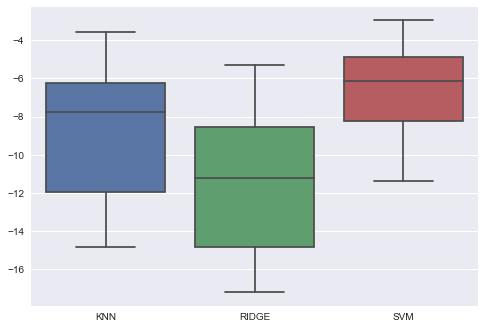

In [22]:
# Put all tuned models together
ResultsTuned = pd.DataFrame(columns=['KNN','RIDGE','SVM'])

#Models
modelsTuned = { 'RIDGE' : Ridge(alpha=0.1,solver='sag'),
           'KNN':  KNeighborsRegressor(n_neighbors=4,weights='distance'),
           'SVM':  SVR(C=100, gamma=1)
        }
for name in ResultsTuned.columns.values:
    pipeline = make_pipeline( HPImputer(),CategoricalTransformer(),scaler, modelsTuned[name] )
    cv_results = cross_val_score(pipeline, Xtrain, ytrain, cv=kfold, scoring=scoring)
    ResultsTuned[name] = cv_results

#Visualize
sns.boxplot(data=ResultsTuned)

Using the hyperparameter tuning, we have increased the accuracy of the regression on the training set. But can we do any better with other methods?

## Ensemble Methods<a class="anchor" id="ensemble"></a>
[[back to top]](#top)

Another way that we could improve the performance of algorithms on this problem is by using ensemble methods. In this section we will evaluate four different ensemble machine learning algorithms, two boosting and two bagging methods for regression:

* **Boosting Methods**: AdaBoost (AB) and Gradient Boosting (GBM).
* **Bagging Methods**: Random Forests (RF) and Extra Trees (ET).

First we will run all of the ensemble methods with default parameters, and then pick one to tune.

AB    -7.9
GBM   -7.6
RF    -7.6
ET    -8.3
dtype: float64

AB     2.7
GBM    3.0
RF     2.6
ET     2.9
dtype: float64

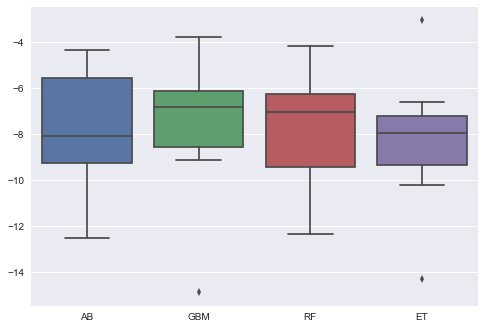

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

#Models
emodels = { 'AB' : AdaBoostRegressor(),
           'GBM': GradientBoostingRegressor(),
           'RF':  RandomForestRegressor(),
           'ET':  ExtraTreesRegressor()
        }
emodelkeys = emodels.keys()

#Evaluate Models
eResults = pd.DataFrame(columns=emodelkeys)
scoring = 'neg_mean_squared_error'
for name in emodelkeys:
    pipeline = make_pipeline(HPImputer(), CategoricalTransformer(), scaler, emodels[name] )
    cv_results = cross_val_score(pipeline, Xtrain, ytrain, cv=kfold, scoring=scoring)
    eResults[name] = cv_results

display(eResults.mean())
display(eResults.std())

#Visualize
sns.boxplot(data=eResults)

## Tuning Ensemble Methods: Gradient Boosting <a class="anchor" id="tuninggbm"></a>
[[back to top]](#top)

Here we will tune the hyperparameters for the Gradient Boosting method, we can perform a grid search over the following parameter space:

* **max_depth**: depth of each individual tree, controls the degree of feature interaction that the model can fit.
* **learning_rate**: how fast/slow the model is optimized. 
* **min_sample_leaf**: another way to control the depth of the trees is to enforce a lower bound on the number of samples in a leaf.

We will use **n_estimators** roughly equal to the sample size.

In [24]:
#Pipeline for Gradient Boosting Regressor 
gbm_pipe = make_pipeline(HPImputer(), CategoricalTransformer(), scaler,
                         GradientBoostingRegressor(random_state=7,loss='ls',n_estimators=240,subsample=0.7) )

#Set up grid search
param_grid = {'gradientboostingregressor__max_depth':[2,3,4],
              'gradientboostingregressor__max_features':[3,4,None],
              'gradientboostingregressor__learning_rate':[0.1,0.02],
              'gradientboostingregressor__min_samples_leaf':[3,4],
             }

#Grid Search - scoring and kfold are same ones used earlier
gs_gbm = GridSearchCV(gbm_pipe, param_grid=param_grid, cv=kfold,scoring=scoring)
gs_gbm.fit(Xtrain, ytrain)

#Print scores
gbm_results =  gs_gbm.cv_results_
report(gbm_results)


Model with rank: 1
Mean validation score: -6.847 (std: 2.016)
Parameters: {'gradientboostingregressor__learning_rate': 0.02, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__max_features': 3, 'gradientboostingregressor__min_samples_leaf': 4}

Model with rank: 2
Mean validation score: -6.877 (std: 2.044)
Parameters: {'gradientboostingregressor__learning_rate': 0.02, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__max_features': 3, 'gradientboostingregressor__min_samples_leaf': 3}

Model with rank: 3
Mean validation score: -7.001 (std: 2.193)
Parameters: {'gradientboostingregressor__learning_rate': 0.02, 'gradientboostingregressor__max_depth': 4, 'gradientboostingregressor__max_features': 4, 'gradientboostingregressor__min_samples_leaf': 3}



Let's add the gradient boosting model to our tuned results, and visualize:

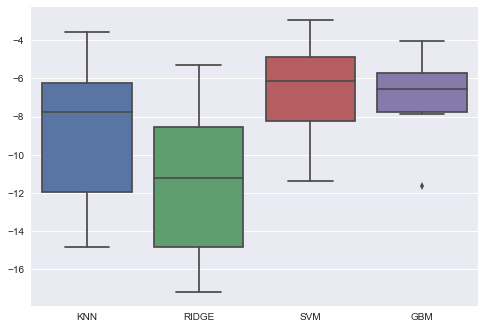

In [25]:
## Add optimized GBM estimator to our tuned models
gbm_pipe.set_params(gradientboostingregressor__n_estimators=240,
                    gradientboostingregressor__subsample=0.7,
                    gradientboostingregressor__loss='ls',
                    gradientboostingregressor__learning_rate=0.02,
                    gradientboostingregressor__max_depth =4,
                    gradientboostingregressor__max_features=3,
                    gradientboostingregressor__min_samples_leaf=4)

ResultsTuned['GBM'] = cross_val_score(gbm_pipe, Xtrain, ytrain, cv=kfold, scoring=scoring)
modelsTuned['GBM']  = gbm_pipe.steps[-1][-1]

#Visualize
sns.boxplot(data=ResultsTuned)

From the above, SVM and GBM are the top performing models using cross-validation on our training dataset. 

## Finalize Models <a class="anchor" id="finalize"></a>
[[back to top]](#top)

Here we will take the best performing models we found above and evaluate them on our hold out validation dataset, compare the mean squared error and then visualize the results and compare.

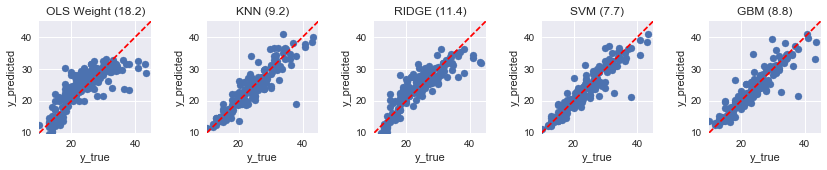

In [26]:
MSEResults=pd.DataFrame(columns=ResultsTuned.columns.values)
for name in ResultsTuned.columns.values:
    pipeline = make_pipeline( HPImputer(),CategoricalTransformer(),scaler, modelsTuned[name] )
    pipeline.fit(Xtrain,ytrain)
    predictions = pipeline.predict(Xtest)
    Predictions['y_{}'.format(name)] = predictions
    MSEResults[name] = [mean_squared_error(predictions,ytest)]
    
#Visualizing Results
fig,axes = plt.subplots(1,len(ResultsTuned.columns.values)+1,figsize=[14,8])
# Plot OLS with weight first
axes[0].scatter(ytest,Predictions['y_LRweight'])
axes[0].plot([10,45],[10,45], 'r--')
axes[0].set_title('OLS Weight ({:0.1f})'.format(lr_mse))
axes[0].set_ylabel('y_predicted');axes[0].set_xlabel('y_true')
axes[0].set_ylim([10,45]);axes[0].set_xlim([10,45])
axes[0].set_aspect('equal')
for name,ax in zip(ResultsTuned.columns.values,axes.ravel()[1:]):
    ax.scatter(ytest,Predictions['y_{}'.format(name)])
    ax.plot([10,45],[10,45], 'r--')
    ax.set_xlabel('y_true');ax.set_ylabel('y_predicted')
    ax.set_title('{} ({:0.1f})'.format(name,MSEResults[name].values[0]))
    ax.set_ylim([10,45]);ax.set_xlim([10,45])
    ax.set_aspect('equal')

fig.subplots_adjust(wspace=0.5)

## Summary <a class="anchor" id="summary"></a>
[[back to top]](#top)

From the above visualization and MSE score on the test data, we see that the Support Vector Machine regressor is the best performer. There is no sign that our tuned models are overfitting the training data, as the test scores lie within the standard deviation of the cross validation scores.

We have reduced the MSE from our first jab using the simple 1 feature least squares linear regression from 18.2 down to 7.7 for the SVM regression model. The corresponding RMSE is 2.77 MPG. 

What does this mean? If a buyer is looking at older model cars from from the 1970's and 1980's and only has a fact sheet with car attributes, we can predict the city consumption fuel efficiency within an error of 2.77 MPG.

## License
The material in this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by-nc/4.0/). 
